In [ ]:
from google.colab import drive

# Montar o Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch torchvision opencv-python


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import densenet121
import torchvision.transforms as transforms

class CustomDataset(Dataset):
    def __init__(self, caminhos_imagens, labels):
        self.imagens = self.carregar_imagens(caminhos_imagens)
        self.labels = labels

    def __len__(self):
        return len(self.imagens)

    def __getitem__(self, index):
        imagem = self.imagens[index]
        label = self.labels[index]
        return imagem, torch.tensor(label)

    def carregar_imagens(self, caminhos_imagens):
        imagens = []
        for caminho_imagem in caminhos_imagens:
            imagem = cv2.imread(caminho_imagem)
            if imagem is None:
                continue
            imagem = cv2.resize(imagem, (128, 128))
            imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
            imagem = torch.tensor(imagem, dtype=torch.float32)
            # Transpor as dimensões das imagens para [3, 128, 128]
            imagem = imagem.permute(2, 0, 1)
            imagens.append(imagem)
        return imagens

class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        self.densenet = densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.densenet(x)

# Caminho para a pasta que contém as imagens
pasta_imagens = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/train/images"

# Caminho para a pasta que contém as anotações (rótulos)
pasta_anotacoes = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/train/mask"

# Lista para armazenar os caminhos das imagens e rótulos
arquivos_imagens = []
arquivos_anotacoes = []

# Percorrer as subpastas "classe 0" e "classe 1"
for classe in ["classe 0", "classe 1"]:
    subpasta_imagens = os.path.join(pasta_imagens, classe)
    subpasta_anotacoes = os.path.join(pasta_anotacoes, classe)
    
    # Obter os caminhos dos arquivos de imagem e anotação (rótulo)
    arquivos_imagens_classe = [os.path.join(subpasta_imagens, nome) for nome in os.listdir(subpasta_imagens)]
    arquivos_anotacoes_classe = [os.path.join(subpasta_anotacoes, nome) for nome in os.listdir(subpasta_anotacoes)]
    
    # Adicionar os caminhos à lista principal
    arquivos_imagens.extend(arquivos_imagens_classe)
    arquivos_anotacoes.extend(arquivos_anotacoes_classe)

if len(arquivos_imagens) == 0 or len(arquivos_anotacoes) == 0:
    print("Nenhum dado válido encontrado. Verifique os caminhos dos arquivos.")
    exit()

# Converter os rótulos para tipo numérico (classe 0: 0, classe 1: 1)
labels = [0 if "classe 0" in arquivo else 1 for arquivo in arquivos_anotacoes]

# Carregar as imagens e rótulos
imagens = CustomDataset(arquivos_imagens, labels)

# Criar DataLoader
dataloader = DataLoader(imagens, batch_size=32, shuffle=True)

# Definir número de classes (glaucoma ou não glaucoma)
num_classes = 2

# Criar modelo DenseNet
model = DenseNet(num_classes)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Treinar o modelo
num_epochs = 10
for epoch in range(num_epochs):
    for imagens_batch, labels_batch in dataloader:
        imagens_batch = imagens_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(imagens_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Salvar o modelo treinado
nome_arquivo_modelo = "modeloDesnetDRIVE.pth"
torch.save(model.state_dict(), nome_arquivo_modelo)
print("Modelo salvo com sucesso!")


In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import densenet121
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class CustomDataset(Dataset):
    def __init__(self, caminhos_imagens, labels):
        self.imagens = self.carregar_imagens(caminhos_imagens)
        self.labels = labels

    def __len__(self):
        return len(self.imagens)

    def __getitem__(self, index):
        imagem = self.imagens[index]
        label = self.labels[index]
        return imagem, label[0]
 

    def carregar_imagens(self, caminhos_imagens):
        imagens = []
        labels = []
        for caminho_imagem in caminhos_imagens:
            imagem = cv2.imread(caminho_imagem)
            if imagem is None:
                continue
            imagem = cv2.resize(imagem, (128, 128))
            imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
            imagens.append(imagem)
    
            # Obter o rótulo da imagem a partir do caminho
            label = os.path.basename(os.path.dirname(caminho_imagem))
            labels.append(label)
    
        return np.array(imagens), labels


class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        self.densenet = densenet121(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        return self.densenet(x)

# Caminho para a pasta que contém as imagens
pasta_imagens = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/train/images"

# Caminho para a pasta que contém as anotações (rótulos)
pasta_anotacoes = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/train/mask"

# Lista para armazenar os caminhos das imagens e rótulos
arquivos_imagens = []
arquivos_anotacoes = []

# Percorrer as subpastas "classe 0" e "classe 1"
for classe in ["classe 0", "classe 1"]:
    subpasta_imagens = os.path.join(pasta_imagens, classe)
    subpasta_anotacoes = os.path.join(pasta_anotacoes, classe)
    
    # Obter os caminhos dos arquivos de imagem e anotação (rótulo)
    arquivos_imagens_classe = [os.path.join(subpasta_imagens, arquivo) for arquivo in os.listdir(subpasta_imagens)]
    arquivos_anotacoes_classe = [os.path.join(subpasta_anotacoes, arquivo) for arquivo in os.listdir(subpasta_anotacoes)]
    
    # Adicionar os caminhos à lista geral
    arquivos_imagens.extend(arquivos_imagens_classe)
    arquivos_anotacoes.extend(arquivos_anotacoes_classe)

# Verificar se há dados carregados
if len(arquivos_imagens) == 0 or len(arquivos_anotacoes) == 0:
    print("Nenhum dado válido encontrado. Verifique os caminhos dos arquivos.")
    exit()

# Carregar as imagens e anotações
imagens = CustomDataset(arquivos_imagens, arquivos_anotacoes)

# Criar DataLoader
dataloader = DataLoader(imagens, batch_size=32, shuffle=True)

# Definir número de classes (glaucoma ou não glaucoma)
num_classes = 2

# Criar modelo DenseNet
model = DenseNet(num_classes)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Treinar o modelo
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0
    epoch_precision = 0.0
    epoch_recall = 0.0
    epoch_f1 = 0.0
    
    for imagens_batch, labels_batch in dataloader:
        imagens_batch = imagens_batch.to(device)
        labels_batch = [int(label) for label in labels_batch]
        labels_batch = torch.tensor(labels_batch, dtype=torch.long)
        labels_batch = labels_batch.to(device)

         
        
        optimizer.zero_grad()
        outputs = model(imagens_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
    
    # Resto do código...

        
        epoch_loss += loss.item() * imagens_batch.size(0)
        
        _, predicted_labels = torch.max(outputs, 1)
        predicted_labels = predicted_labels.cpu().numpy()
        labels_batch = labels_batch.cpu().numpy()
        
        epoch_acc += accuracy_score(labels_batch, predicted_labels) * imagens_batch.size(0)
        epoch_precision += precision_score(labels_batch, predicted_labels) * imagens_batch.size(0)
        epoch_recall += recall_score(labels_batch, predicted_labels) * imagens_batch.size(0)
        epoch_f1 += f1_score(labels_batch, predicted_labels) * imagens_batch.size(0)
    
    epoch_loss /= len(imagens)
    epoch_acc /= len(imagens)
    epoch_precision /= len(imagens)
    epoch_recall /= len(imagens)
    epoch_f1 /= len(imagens)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1-score: {epoch_f1:.4f}")

# Salvar o modelo treinado
nome_arquivo_modelo = "/content/drive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/"
model.save(nome_arquivo_modelo)
print("Modelo salvo com sucesso!")


AttributeError: ignored

In [19]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose
from PIL import Image
import torchvision.models as models

# Definir a classe do conjunto de dados
class GlaucomaDataset(Dataset):
    def __init__(self, root_dir, annotation_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.classes = ['classe 0', 'classe 1']
        self.transform = transform
        self.train = train
        self.images = []
        self.labels = []
        self.annotations = []
        for class_idx, class_dir in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_dir)
            annotation_path = os.path.join(self.annotation_dir, class_dir)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(class_idx)
                annotation_name = image_name.replace('.png', '.txt')
                annotation_file = os.path.join(annotation_path, annotation_name)
                self.annotations.append(annotation_file)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx], cv2.IMREAD_UNCHANGED)  # Carregar a imagem no formato PNG
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        annotation = self.annotations[idx]

        if self.train:
            return image, label, annotation
        else:
            return image, label


# Definir as transformações a serem aplicadas nas imagens
transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

# Definir a arquitetura DenseNet
class DenseNet(nn.Module):
    def __init__(self, num_classes):
        super(DenseNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.densenet(x)


# Definir os caminhos para as pastas de treinamento e teste
train_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/REFUGE/train"
train_annotation_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/REFUGE/train extra/Masks"

test_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/REFUGE/test/Images"
test_annotation_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/REFUGE/test/Masks"

# Criar o conjunto de dados de treinamento e teste
train_dataset = GlaucomaDataset(train_folder, train_annotation_folder, transform=transform, train=True)
test_dataset = GlaucomaDataset(test_folder, test_annotation_folder, transform=transform, train=False)

# Criar os dataloaders para carregar os dados durante o treinamento e teste
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Criar a instância do modelo DenseNet
model = DenseNet(num_classes=1)

# Definir a função de perda e o otimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Treinar o modelo
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels, _ in train_dataloader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Avaliar o modelo após cada epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy:.4f}")
    # Salvar o modelo treinado
    nome_arquivo_modelo = "/content/drive/MyDrive/compara_segmentadores/data2/A/REFUGE/ops6.pth"
    torch.save(model.state_dict(), nome_arquivo_modelo)
    print("Modelo salvo com sucesso!")  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.9355
Epoch 1/10, Accuracy: 0.9048
Modelo salvo com sucesso!
Epoch 2/10, Loss: 0.3920
Epoch 2/10, Accuracy: 0.9048
Modelo salvo com sucesso!
Epoch 3/10, Loss: 0.3721
Epoch 3/10, Accuracy: 0.9048
Modelo salvo com sucesso!
Epoch 4/10, Loss: 0.3288
Epoch 4/10, Accuracy: 0.9048
Modelo salvo com sucesso!
Epoch 5/10, Loss: 0.3298
Epoch 5/10, Accuracy: 0.9048
Modelo salvo com sucesso!
Epoch 6/10, Loss: 0.3491
Epoch 6/10, Accuracy: 0.9048
Modelo salvo com sucesso!
Epoch 7/10, Loss: 0.3037
Epoch 7/10, Accuracy: 0.9023
Modelo salvo com sucesso!
Epoch 8/10, Loss: 0.3059
Epoch 8/10, Accuracy: 0.9048
Modelo salvo com sucesso!
Epoch 9/10, Loss: 0.3121
Epoch 9/10, Accuracy: 0.9048
Modelo salvo com sucesso!
Epoch 10/10, Loss: 0.2635
Epoch 10/10, Accuracy: 0.9048
Modelo salvo com sucesso!


In [ ]:
model.load_state_dict(torch.load(nome_arquivo_modelo))

<All keys matched successfully>

Performance metrics on the test set:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        24
           1       0.00      0.00      0.00        16

    accuracy                           0.60        40
   macro avg       0.30      0.50      0.37        40
weighted avg       0.36      0.60      0.45        40

-----------------------------------
Summary for 40 test images:
Accuracy: 60.00%
Precision: 30.00%
Recall: 50.00%
F1-score: 37.50%
-----------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

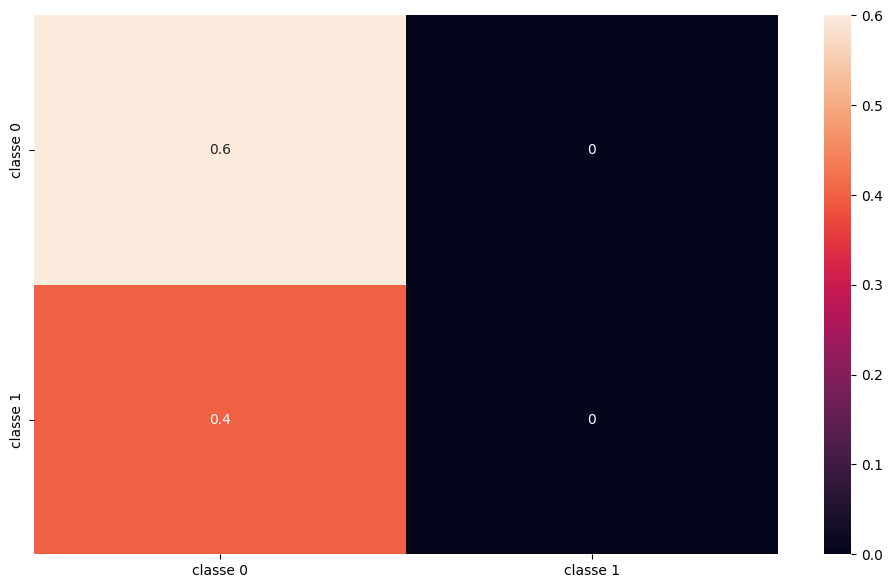

In [21]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torchvision.models as models

# Define the neural network architecture with transfer learning
class GlaucomaClassifier(nn.Module):
    def __init__(self):
        super(GlaucomaClassifier, self).__init__()
        self.features = models.densenet121(pretrained=True)
        num_ftrs = self.features.classifier.in_features
        self.features.classifier = nn.Linear(num_ftrs, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x


# Define the desired size to resize the images
image_size = (224, 224)  # Replace with your desired sizes

# Transformation to resize the images
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/test/", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

model = GlaucomaClassifier()

# Load the state_dict from the saved model
state_dict = torch.load("/content/drive/MyDrive/compara_segmentadores/data2/A/REFUGE/ops6.pth")

# Load the adjusted state_dict into the model
model.load_state_dict(state_dict, strict=False)

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Generate predictions for the test set
model.eval()
preds = []
targets = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        _, predicted = torch.max(outputs, 1)

        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

# Calculate the confusion matrix
confusion_mat = confusion_matrix(targets, preds)

# Normalize the matrix to the range 0 and 1 and round each cell to 2 decimal places
normalized_mat = np.round(confusion_mat / np.sum(confusion_mat), 2)

# Convert the matrix to the format expected by the Pandas library
classes = dataset.classes
df_confusion = pd.DataFrame(normalized_mat, index=classes, columns=[i for i in classes])

# Generate a heatmap image
plt.figure(figsize=(12, 7))
sn.heatmap(df_confusion, annot=True)
plt.savefig('confusion_matrix.png')

# Print performance metrics
print('Performance metrics on the test set:')
print(classification_report(targets, preds))

precision, recall, fscore, support = precision_recall_fscore_support(targets, preds, average='macro')

print('-----------------------------------')
print(f'Summary for {len(dataset)} test images:')
print(f"Accuracy: {(100 * np.sum(np.array(preds) == np.array(targets)) / len(targets)):.2f}%")
print(f"Precision: {100 * precision:.2f}%")
print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * fscore:.2f}%")
print('-----------------------------------')


In [3]:
import os 
from google.colab import drive
drive.mount('/content/drive')
print(os.listdir(('/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/train/')))
print(train_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['classe 1', 'classe 0']
/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/train


In [ ]:
state_dict.keys()

In [14]:
import os
import json

diretorio = '/content/drive/MyDrive/compara_segmentadores/data2/A/REFUGE/train/'  # Insira o caminho para o diretório contendo os arquivos JSON

nomes_arquivos_label_0 = []

for nome_arquivo in os.listdir(diretorio):
    if nome_arquivo.endswith('.json'):  # Verifica se o arquivo tem extensão .json
        caminho_arquivo = os.path.join(diretorio, nome_arquivo)
       
        with open(caminho_arquivo) as arquivo:
            dados_json = json.load(arquivo)
            print(dados_json)
            if 'Label' in dados_json and dados_json['Label'] == 0:
                print("f")
                nomes_arquivos_label_0.append(nome_arquivo)

print(nomes_arquivos_label_0)


{'0': {'ImgName': 'g0001.jpg', 'Fovea_X': 1057.95, 'Fovea_Y': 1076.52, 'Size_X': 2124, 'Size_Y': 2056, 'Label': 1}, '1': {'ImgName': 'g0002.jpg', 'Fovea_X': 1190.59, 'Fovea_Y': 1017.09, 'Size_X': 2124, 'Size_Y': 2056, 'Label': 1}, '2': {'ImgName': 'g0003.jpg', 'Fovea_X': 1070.56, 'Fovea_Y': 1084.85, 'Size_X': 2124, 'Size_Y': 2056, 'Label': 1}, '3': {'ImgName': 'g0004.jpg', 'Fovea_X': 1072.6, 'Fovea_Y': 1035.48, 'Size_X': 2124, 'Size_Y': 2056, 'Label': 1}, '4': {'ImgName': 'g0005.jpg', 'Fovea_X': 1058.19, 'Fovea_Y': 1100.33, 'Size_X': 2124, 'Size_Y': 2056, 'Label': 1}, '5': {'ImgName': 'g0006.jpg', 'Fovea_X': 1075.14, 'Fovea_Y': 1081.93, 'Size_X': 2124, 'Size_Y': 2056, 'Label': 1}, '6': {'ImgName': 'g0007.jpg', 'Fovea_X': 1091.85, 'Fovea_Y': 1095.8, 'Size_X': 2124, 'Size_Y': 2056, 'Label': 1}, '7': {'ImgName': 'g0008.jpg', 'Fovea_X': 1127.47, 'Fovea_Y': 1070.25, 'Size_X': 2124, 'Size_Y': 2056, 'Label': 1}, '8': {'ImgName': 'g0009.jpg', 'Fovea_X': 1265.35, 'Fovea_Y': 1091.75, 'Size_X': 2

In [17]:
import json
import os
import shutil

dados_json = '''
{
    "0": {"ImgName": "g0001.jpg", "Fovea_X": 1057.95, "Fovea_Y": 1076.52, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "1": {"ImgName": "g0002.jpg", "Fovea_X": 1190.59, "Fovea_Y": 1017.09, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "2": {"ImgName": "g0003.jpg", "Fovea_X": 1070.56, "Fovea_Y": 1084.85, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "3": {"ImgName": "g0004.jpg", "Fovea_X": 1072.6, "Fovea_Y": 1035.48, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "4": {"ImgName": "g0005.jpg", "Fovea_X": 1058.19, "Fovea_Y": 1100.33, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "5": {"ImgName": "g0006.jpg", "Fovea_X": 1075.14, "Fovea_Y": 1081.93, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "6": {"ImgName": "g0007.jpg", "Fovea_X": 1091.85, "Fovea_Y": 1095.8, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "7": {"ImgName": "g0008.jpg", "Fovea_X": 1127.47, "Fovea_Y": 1070.25, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "8": {"ImgName": "g0009.jpg", "Fovea_X": 1265.35, "Fovea_Y": 1091.75, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "9": {"ImgName": "g0010.jpg", "Fovea_X": 1310.76, "Fovea_Y": 1074.7, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "10": {"ImgName": "g0011.jpg", "Fovea_X": 1097.92, "Fovea_Y": 1004.36, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "11": {"ImgName": "g0012.jpg", "Fovea_X": 1246.95, "Fovea_Y": 1107.41, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "12": {"ImgName": "g0013.jpg", "Fovea_X": 1137.41, "Fovea_Y": 1288.77, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "13": {"ImgName": "g0014.jpg", "Fovea_X": 1133.61, "Fovea_Y": 1084.37, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "14": {"ImgName": "g0015.jpg", "Fovea_X": 1143.83, "Fovea_Y": 1111.45, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "15": {"ImgName": "g0016.jpg", "Fovea_X": 1151.34, "Fovea_Y": 1075.1, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "16": {"ImgName": "g0017.jpg", "Fovea_X": 1094.52, "Fovea_Y": 1041.29, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "17": {"ImgName": "g0018.jpg", "Fovea_X": 1062.21, "Fovea_Y": 1115.76, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "18": {"ImgName": "g0019.jpg", "Fovea_X": 1070.41, "Fovea_Y": 1057.36, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "19": {"ImgName": "g0020.jpg", "Fovea_X": 1115.41, "Fovea_Y": 1088.87, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "20": {"ImgName": "g0021.jpg", "Fovea_X": 1105.63, "Fovea_Y": 1028.03, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "21": {"ImgName": "g0022.jpg", "Fovea_X": 1402.13, "Fovea_Y": 1064.83, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "22": {"ImgName": "g0023.jpg", "Fovea_X": 1499.78, "Fovea_Y": 1056.3, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "23": {"ImgName": "g0024.jpg", "Fovea_X": 1092.16, "Fovea_Y": 1194.93, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "24": {"ImgName": "g0025.jpg", "Fovea_X": 1163.63, "Fovea_Y": 1111.95, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "25": {"ImgName": "g0026.jpg", "Fovea_X": 1220.36, "Fovea_Y": 1119.64, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "26": {"ImgName": "g0027.jpg", "Fovea_X": 1070.75, "Fovea_Y": 1077.47, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "27": {"ImgName": "g0028.jpg", "Fovea_X": 1077.6, "Fovea_Y": 1070.07, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "28": {"ImgName": "g0029.jpg", "Fovea_X": 1086.97, "Fovea_Y": 1086.75, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "29": {"ImgName": "g0030.jpg", "Fovea_X": 1080.88, "Fovea_Y": 1067.03, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "30": {"ImgName": "g0031.jpg", "Fovea_X": 1058.13, "Fovea_Y": 1069.44, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "31": {"ImgName": "g0032.jpg", "Fovea_X": 1061.67, "Fovea_Y": 1073.74, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "32": {"ImgName": "g0033.jpg", "Fovea_X": 1048.08, "Fovea_Y": 1075.2, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "33": {"ImgName": "g0034.jpg", "Fovea_X": 1133.72, "Fovea_Y": 1082.66, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "34": {"ImgName": "g0035.jpg", "Fovea_X": 1151.75, "Fovea_Y": 1110.96, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "35": {"ImgName": "g0036.jpg", "Fovea_X": 1206.07, "Fovea_Y": 1031.24, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "36": {"ImgName": "g0037.jpg", "Fovea_X": 1152.65, "Fovea_Y": 1114.19, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "37": {"ImgName": "g0038.jpg", "Fovea_X": 1102.04, "Fovea_Y": 1043.61, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "38": {"ImgName": "g0039.jpg", "Fovea_X": 1071.49, "Fovea_Y": 1077.97, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "39": {"ImgName": "g0040.jpg", "Fovea_X": 1119.18, "Fovea_Y": 893.36, "Size_X": 2124, "Size_Y": 2056, "Label": 1}, 
    "40": {"ImgName": "n0001.jpg", "Fovea_X": 1193.77, "Fovea_Y": 1123.78, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "41": {"ImgName": "n0002.jpg", "Fovea_X": 1199.42, "Fovea_Y": 1085.25, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "42": {"ImgName": "n0003.jpg", "Fovea_X": 1322.12, "Fovea_Y": 1085.19, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "43": {"ImgName": "n0004.jpg", "Fovea_X": 1038.84, "Fovea_Y": 1037.2, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "44": {"ImgName": "n0005.jpg", "Fovea_X": 1088.56, "Fovea_Y": 1027.56, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "45": {"ImgName": "n0006.jpg", "Fovea_X": 1184.17, "Fovea_Y": 1061.39, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "46": {"ImgName": "n0007.jpg", "Fovea_X": 1102.03, "Fovea_Y": 1055.86, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "47": {"ImgName": "n0008.jpg", "Fovea_X": 1049.51, "Fovea_Y": 1062.6, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "48": {"ImgName": "n0009.jpg", "Fovea_X": 1236.65, "Fovea_Y": 1040.19, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "49": {"ImgName": "n0010.jpg", "Fovea_X": 1140.89, "Fovea_Y": 1001.93, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "50": {"ImgName": "n0011.jpg", "Fovea_X": 1286.78, "Fovea_Y": 1169.62, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "51": {"ImgName": "n0012.jpg", "Fovea_X": 1267.0, "Fovea_Y": 1048.21, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "52": {"ImgName": "n0013.jpg", "Fovea_X": 1047.12, "Fovea_Y": 1057.25, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "53": {"ImgName": "n0014.jpg", "Fovea_X": 1153.49, "Fovea_Y": 1098.82, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "54": {"ImgName": "n0015.jpg", "Fovea_X": 1043.27, "Fovea_Y": 1079.86, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "55": {"ImgName": "n0016.jpg", "Fovea_X": 1183.8, "Fovea_Y": 1117.87, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "56": {"ImgName": "n0017.jpg", "Fovea_X": 1230.03, "Fovea_Y": 1083.15, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "57": {"ImgName": "n0018.jpg", "Fovea_X": 1202.56, "Fovea_Y": 1019.24, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "58": {"ImgName": "n0019.jpg", "Fovea_X": 1087.52, "Fovea_Y": 1065.89, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "59": {"ImgName": "n0020.jpg", "Fovea_X": 1066.77, "Fovea_Y": 1004.71, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "60": {"ImgName": "n0021.jpg", "Fovea_X": 1168.55, "Fovea_Y": 1046.88, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "61": {"ImgName": "n0022.jpg", "Fovea_X": 1057.79, "Fovea_Y": 1061.81, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "62": {"ImgName": "n0023.jpg", "Fovea_X": 1040.04, "Fovea_Y": 1072.08, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "63": {"ImgName": "n0024.jpg", "Fovea_X": 1074.05, "Fovea_Y": 1024.77, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "64": {"ImgName": "n0025.jpg", "Fovea_X": 1113.73, "Fovea_Y": 1126.87, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "65": {"ImgName": "n0026.jpg", "Fovea_X": 1045.32, "Fovea_Y": 1064.63, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "66": {"ImgName": "n0027.jpg", "Fovea_X": 1074.98, "Fovea_Y": 1094.59, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "67": {"ImgName": "n0028.jpg", "Fovea_X": 1058.03, "Fovea_Y": 1065.08, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "68": {"ImgName": "n0029.jpg", "Fovea_X": 1041.23, "Fovea_Y": 1066.08, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "69": {"ImgName": "n0030.jpg", "Fovea_X": 1104.34, "Fovea_Y": 937.64, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "70": {"ImgName": "n0031.jpg", "Fovea_X": 1060.26, "Fovea_Y": 992.9, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "71": {"ImgName": "n0032.jpg", "Fovea_X": 1080.12, "Fovea_Y": 1055.38, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "72": {"ImgName": "n0033.jpg", "Fovea_X": 1077.9, "Fovea_Y": 1073.42, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "73": {"ImgName": "n0034.jpg", "Fovea_X": 1069.15, "Fovea_Y": 1073.13, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "74": {"ImgName": "n0035.jpg", "Fovea_X": 1088.65, "Fovea_Y": 1068.06, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "75": {"ImgName": "n0036.jpg", "Fovea_X": 1059.85, "Fovea_Y": 1065.39, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "76": {"ImgName": "n0037.jpg", "Fovea_X": 1234.91, "Fovea_Y": 1040.85, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "77": {"ImgName": "n0038.jpg", "Fovea_X": 1083.0, "Fovea_Y": 1078.48, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "78": {"ImgName": "n0039.jpg", "Fovea_X": 1111.18, "Fovea_Y": 1044.16, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "79": {"ImgName": "n0040.jpg", "Fovea_X": 1051.32, "Fovea_Y": 1049.19, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "80": {"ImgName": "n0041.jpg", "Fovea_X": 1137.14, "Fovea_Y": 1089.52, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "81": {"ImgName": "n0042.jpg", "Fovea_X": 1083.62, "Fovea_Y": 1035.67, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "82": {"ImgName": "n0043.jpg", "Fovea_X": 1057.92, "Fovea_Y": 1076.15, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "83": {"ImgName": "n0044.jpg", "Fovea_X": 1041.52, "Fovea_Y": 1081.12, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "84": {"ImgName": "n0045.jpg", "Fovea_X": 1241.02, "Fovea_Y": 1021.34, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "85": {"ImgName": "n0046.jpg", "Fovea_X": 1170.7, "Fovea_Y": 1024.64, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "86": {"ImgName": "n0047.jpg", "Fovea_X": 1084.74, "Fovea_Y": 1071.22, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "87": {"ImgName": "n0048.jpg", "Fovea_X": 1053.43, "Fovea_Y": 1085.43, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "88": {"ImgName": "n0049.jpg", "Fovea_X": 1082.86, "Fovea_Y": 1064.48, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "89": {"ImgName": "n0050.jpg", "Fovea_X": 1069.68, "Fovea_Y": 1066.34, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "90": {"ImgName": "n0051.jpg", "Fovea_X": 1439.52, "Fovea_Y": 1061.73, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "91": {"ImgName": "n0052.jpg", "Fovea_X": 1074.98, "Fovea_Y": 1078.11, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "92": {"ImgName": "n0053.jpg", "Fovea_X": 1122.65, "Fovea_Y": 1090.42, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "93": {"ImgName": "n0054.jpg", "Fovea_X": 1099.85, "Fovea_Y": 993.86, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "94": {"ImgName": "n0055.jpg", "Fovea_X": 1044.31, "Fovea_Y": 1006.85, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "95": {"ImgName": "n0056.jpg", "Fovea_X": 1084.87, "Fovea_Y": 1040.02, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "96": {"ImgName": "n0057.jpg", "Fovea_X": 1111.98, "Fovea_Y": 1165.51, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "97": {"ImgName": "n0058.jpg", "Fovea_X": 1045.49, "Fovea_Y": 1034.14, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "98": {"ImgName": "n0059.jpg", "Fovea_X": 1091.35, "Fovea_Y": 1036.39, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "99": {"ImgName": "n0060.jpg", "Fovea_X": 1121.65, "Fovea_Y": 1049.07, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "100": {"ImgName": "n0061.jpg", "Fovea_X": 1019.82, "Fovea_Y": 1027.03, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "101": {"ImgName": "n0062.jpg", "Fovea_X": 1102.17, "Fovea_Y": 1035.31, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "102": {"ImgName": "n0063.jpg", "Fovea_X": 1039.21, "Fovea_Y": 1037.66, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "103": {"ImgName": "n0064.jpg", "Fovea_X": 1085.68, "Fovea_Y": 1038.06, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "104": {"ImgName": "n0065.jpg", "Fovea_X": 1319.48, "Fovea_Y": 1040.5, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "105": {"ImgName": "n0066.jpg", "Fovea_X": 1138.85, "Fovea_Y": 1150.34, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "106": {"ImgName": "n0067.jpg", "Fovea_X": 1027.0, "Fovea_Y": 1064.36, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "107": {"ImgName": "n0068.jpg", "Fovea_X": 1114.4, "Fovea_Y": 1032.94, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "108": {"ImgName": "n0069.jpg", "Fovea_X": 1095.41, "Fovea_Y": 1053.64, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "109": {"ImgName": "n0070.jpg", "Fovea_X": 1180.65, "Fovea_Y": 1076.25, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "110": {"ImgName": "n0071.jpg", "Fovea_X": 1092.24, "Fovea_Y": 1049.97, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "111": {"ImgName": "n0072.jpg", "Fovea_X": 1064.93, "Fovea_Y": 1010.99, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "112": {"ImgName": "n0073.jpg", "Fovea_X": 1107.18, "Fovea_Y": 1053.52, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "113": {"ImgName": "n0074.jpg", "Fovea_X": 1029.47, "Fovea_Y": 1042.39, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "114": {"ImgName": "n0075.jpg", "Fovea_X": 1095.92, "Fovea_Y": 1041.46, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "115": {"ImgName": "n0076.jpg", "Fovea_X": 1109.26, "Fovea_Y": 1026.63, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "116": {"ImgName": "n0077.jpg", "Fovea_X": 1111.14, "Fovea_Y": 1028.42, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "117": {"ImgName": "n0078.jpg", "Fovea_X": 1284.97, "Fovea_Y": 1025.2, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "118": {"ImgName": "n0079.jpg", "Fovea_X": 1096.25, "Fovea_Y": 1064.66, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "119": {"ImgName": "n0080.jpg", "Fovea_X": 1305.02, "Fovea_Y": 1153.89, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "120": {"ImgName": "n0081.jpg", "Fovea_X": 1465.11, "Fovea_Y": 1126.24, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "121": {"ImgName": "n0082.jpg", "Fovea_X": 1119.43, "Fovea_Y": 1186.8, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "122": {"ImgName": "n0083.jpg", "Fovea_X": 1161.69, "Fovea_Y": 1086.31, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "123": {"ImgName": "n0084.jpg", "Fovea_X": 1471.43, "Fovea_Y": 1080.75, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "124": {"ImgName": "n0085.jpg", "Fovea_X": 1061.56, "Fovea_Y": 1017.04, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "125": {"ImgName": "n0086.jpg", "Fovea_X": 1058.4, "Fovea_Y": 1014.58, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "126": {"ImgName": "n0087.jpg", "Fovea_X": 1354.56, "Fovea_Y": 1152.9, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "127": {"ImgName": "n0088.jpg", "Fovea_X": 1293.09, "Fovea_Y": 1175.53, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "128": {"ImgName": "n0089.jpg", "Fovea_X": 1326.12, "Fovea_Y": 1086.35, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "129": {"ImgName": "n0090.jpg", "Fovea_X": 1307.6, "Fovea_Y": 1130.63, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "130": {"ImgName": "n0091.jpg", "Fovea_X": 1093.65, "Fovea_Y": 1014.47, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "131": {"ImgName": "n0092.jpg", "Fovea_X": 1070.98, "Fovea_Y": 1022.82, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "132": {"ImgName": "n0093.jpg", "Fovea_X": 1317.78, "Fovea_Y": 1025.68, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "133": {"ImgName": "n0094.jpg", "Fovea_X": 1014.32, "Fovea_Y": 1054.07, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "134": {"ImgName": "n0095.jpg", "Fovea_X": 1123.18, "Fovea_Y": 1031.97, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "135": {"ImgName": "n0096.jpg", "Fovea_X": 1358.72, "Fovea_Y": 1116.3, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "136": {"ImgName": "n0097.jpg", "Fovea_X": 1298.04, "Fovea_Y": 1026.74, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "137": {"ImgName": "n0098.jpg", "Fovea_X": 1068.53, "Fovea_Y": 1016.44, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "138": {"ImgName": "n0099.jpg", "Fovea_X": 1022.3, "Fovea_Y": 1032.72, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "139": {"ImgName": "n0100.jpg", "Fovea_X": 1121.86, "Fovea_Y": 1011.55, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "140": {"ImgName": "n0101.jpg", "Fovea_X": 1038.48, "Fovea_Y": 1058.04, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "141": {"ImgName": "n0102.jpg", "Fovea_X": 1108.0, "Fovea_Y": 1083.71, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "142": {"ImgName": "n0103.jpg", "Fovea_X": 1198.06, "Fovea_Y": 1156.76, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "143": {"ImgName": "n0104.jpg", "Fovea_X": 1229.26, "Fovea_Y": 803.88, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "144": {"ImgName": "n0105.jpg", "Fovea_X": 1060.38, "Fovea_Y": 1066.08, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "145": {"ImgName": "n0106.jpg", "Fovea_X": 1253.28, "Fovea_Y": 1075.73, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "146": {"ImgName": "n0107.jpg", "Fovea_X": 1343.43, "Fovea_Y": 1093.47, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "147": {"ImgName": "n0108.jpg", "Fovea_X": 1196.21, "Fovea_Y": 1093.85, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "148": {"ImgName": "n0109.jpg", "Fovea_X": 1138.57, "Fovea_Y": 1052.6, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "149": {"ImgName": "n0110.jpg", "Fovea_X": 1063.59, "Fovea_Y": 1036.68, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "150": {"ImgName": "n0111.jpg", "Fovea_X": 1279.87, "Fovea_Y": 1152.52, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "151": {"ImgName": "n0112.jpg", "Fovea_X": 1089.88, "Fovea_Y": 1037.43, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "152": {"ImgName": "n0113.jpg", "Fovea_X": 1294.83, "Fovea_Y": 1083.39, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "153": {"ImgName": "n0114.jpg", "Fovea_X": 1320.77, "Fovea_Y": 1130.06, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "154": {"ImgName": "n0115.jpg", "Fovea_X": 1299.73, "Fovea_Y": 1059.12, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "155": {"ImgName": "n0116.jpg", "Fovea_X": 1347.49, "Fovea_Y": 1071.55, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "156": {"ImgName": "n0117.jpg", "Fovea_X": 1223.46, "Fovea_Y": 990.6, "Size_X": 2124, "Size_Y": 2056, "Label": 0},
    "157": {"ImgName": "n0118.jpg", "Fovea_X": 1047.01, "Fovea_Y": 1057.35, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "158": {"ImgName": "n0119.jpg", "Fovea_X": 1218.5, "Fovea_Y": 1100.91, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "159": {"ImgName": "n0120.jpg", "Fovea_X": 1290.1, "Fovea_Y": 1099.89, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "160": {"ImgName": "n0121.jpg", "Fovea_X": 1381.91, "Fovea_Y": 1075.5, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "161": {"ImgName": "n0122.jpg", "Fovea_X": 1325.04, "Fovea_Y": 1082.09, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "162": {"ImgName": "n0123.jpg", "Fovea_X": 1217.2, "Fovea_Y": 1030.71, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "163": {"ImgName": "n0124.jpg", "Fovea_X": 1086.28, "Fovea_Y": 1016.1, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "164": {"ImgName": "n0125.jpg", "Fovea_X": 1252.85, "Fovea_Y": 1092.07, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "165": {"ImgName": "n0126.jpg", "Fovea_X": 1313.09, "Fovea_Y": 1088.24, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "166": {"ImgName": "n0127.jpg", "Fovea_X": 1312.61, "Fovea_Y": 1085.43, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "167": {"ImgName": "n0128.jpg", "Fovea_X": 1345.89, "Fovea_Y": 1055.22, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "168": {"ImgName": "n0129.jpg", "Fovea_X": 1047.54, "Fovea_Y": 1032.07, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "169": {"ImgName": "n0130.jpg", "Fovea_X": 1112.44, "Fovea_Y": 1019.72, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "170": {"ImgName": "n0131.jpg", "Fovea_X": 1256.6, "Fovea_Y": 1248.82, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "171": {"ImgName": "n0132.jpg", "Fovea_X": 1202.19, "Fovea_Y": 1177.87, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "172": {"ImgName": "n0133.jpg", "Fovea_X": 1448.81, "Fovea_Y": 991.92, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "173": {"ImgName": "n0134.jpg", "Fovea_X": 1292.4, "Fovea_Y": 1091.09, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "174": {"ImgName": "n0135.jpg", "Fovea_X": 1308.03, "Fovea_Y": 1017.44, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "175": {"ImgName": "n0136.jpg", "Fovea_X": 1213.99, "Fovea_Y": 1021.51, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "176": {"ImgName": "n0137.jpg", "Fovea_X": 1048.99, "Fovea_Y": 1055.7, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "177": {"ImgName": "n0138.jpg", "Fovea_X": 1097.25, "Fovea_Y": 1025.06, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "178": {"ImgName": "n0139.jpg", "Fovea_X": 1206.45, "Fovea_Y": 1048.0, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "179": {"ImgName": "n0140.jpg", "Fovea_X": 1331.73, "Fovea_Y": 1047.02, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "180": {"ImgName": "n0141.jpg", "Fovea_X": 1244.64, "Fovea_Y": 1079.58, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "181": {"ImgName": "n0142.jpg", "Fovea_X": 1323.88, "Fovea_Y": 1095.61, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "182": {"ImgName": "n0143.jpg", "Fovea_X": 1047.05, "Fovea_Y": 1033.15, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "183": {"ImgName": "n0144.jpg", "Fovea_X": 1253.4, "Fovea_Y": 1041.31, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "184": {"ImgName": "n0145.jpg", "Fovea_X": 1081.24, "Fovea_Y": 1047.01, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "185": {"ImgName": "n0146.jpg", "Fovea_X": 1316.69, "Fovea_Y": 1019.39, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "186": {"ImgName": "n0147.jpg", "Fovea_X": 1038.86, "Fovea_Y": 1067.62, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "187": {"ImgName": "n0148.jpg", "Fovea_X": 1200.85, "Fovea_Y": 1041.06, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "188": {"ImgName": "n0149.jpg", "Fovea_X": 1250.86, "Fovea_Y": 1016.74, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "189": {"ImgName": "n0150.jpg", "Fovea_X": 1076.37, "Fovea_Y": 1028.05, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "190": {"ImgName": "n0151.jpg", "Fovea_X": 1128.37, "Fovea_Y": 1038.47, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "191": {"ImgName": "n0152.jpg", "Fovea_X": 1098.91, "Fovea_Y": 1035.85, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "192": {"ImgName": "n0153.jpg", "Fovea_X": 1067.05, "Fovea_Y": 1075.4, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "193": {"ImgName": "n0154.jpg", "Fovea_X": 1295.22, "Fovea_Y": 1189.23, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "194": {"ImgName": "n0155.jpg", "Fovea_X": 1318.63, "Fovea_Y": 1075.72, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "195": {"ImgName": "n0156.jpg", "Fovea_X": 1023.86, "Fovea_Y": 1055.11, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "196": {"ImgName": "n0157.jpg", "Fovea_X": 1073.68, "Fovea_Y": 1024.26, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "197": {"ImgName": "n0158.jpg", "Fovea_X": 1120.99, "Fovea_Y": 1036.3, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "198": {"ImgName": "n0159.jpg", "Fovea_X": 1174.47, "Fovea_Y": 1137.23, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "199": {"ImgName": "n0160.jpg", "Fovea_X": 1246.16, "Fovea_Y": 1110.8, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "200": {"ImgName": "n0161.jpg", "Fovea_X": 1234.73, "Fovea_Y": 1055.73, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "201": {"ImgName": "n0162.jpg", "Fovea_X": 1006.79, "Fovea_Y": 1081.61, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "202": {"ImgName": "n0163.jpg", "Fovea_X": 1071.78, "Fovea_Y": 1061.38, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "203": {"ImgName": "n0164.jpg", "Fovea_X": 1319.54, "Fovea_Y": 1056.33, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "204": {"ImgName": "n0165.jpg", "Fovea_X": 1079.29, "Fovea_Y": 763.77, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "205": {"ImgName": "n0166.jpg", "Fovea_X": 1145.65, "Fovea_Y": 1046.02, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "206": {"ImgName": "n0167.jpg", "Fovea_X": 1238.8, "Fovea_Y": 1047.5, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "207": {"ImgName": "n0168.jpg", "Fovea_X": 1079.29, "Fovea_Y": 1070.59, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "208": {"ImgName": "n0169.jpg", "Fovea_X": 1054.57, "Fovea_Y": 1060.85, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "209": {"ImgName": "n0170.jpg", "Fovea_X": 1164.83, "Fovea_Y": 1072.26, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "210": {"ImgName": "n0171.jpg", "Fovea_X": 1124.31, "Fovea_Y": 1123.61, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "211": {"ImgName": "n0172.jpg", "Fovea_X": 1236.65, "Fovea_Y": 1086.72, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "212": {"ImgName": "n0173.jpg", "Fovea_X": 1092.77, "Fovea_Y": 1016.76, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "213": {"ImgName": "n0174.jpg", "Fovea_X": 1046.03, "Fovea_Y": 1027.04, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "214": {"ImgName": "n0175.jpg", "Fovea_X": 1063.86, "Fovea_Y": 1026.61, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "215": {"ImgName": "n0176.jpg", "Fovea_X": 1132.06, "Fovea_Y": 1006.99, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "216": {"ImgName": "n0177.jpg", "Fovea_X": 1109.19, "Fovea_Y": 1047.88, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "217": {"ImgName": "n0178.jpg", "Fovea_X": 1174.5, "Fovea_Y": 949.73, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "218": {"ImgName": "n0179.jpg", "Fovea_X": 1100.84, "Fovea_Y": 1056.8, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "219": {"ImgName": "n0180.jpg", "Fovea_X": 1140.58, "Fovea_Y": 1062.0, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "220": {"ImgName": "n0181.jpg", "Fovea_X": 1093.77, "Fovea_Y": 1028.51, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "221": {"ImgName": "n0182.jpg", "Fovea_X": 1195.72, "Fovea_Y": 1073.25, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "222": {"ImgName": "n0183.jpg", "Fovea_X": 1236.27, "Fovea_Y": 1026.42, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "223": {"ImgName": "n0184.jpg", "Fovea_X": 1242.73, "Fovea_Y": 1038.22, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "224": {"ImgName": "n0185.jpg", "Fovea_X": 1305.77, "Fovea_Y": 1030.47, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "225": {"ImgName": "n0186.jpg", "Fovea_X": 1175.77, "Fovea_Y": 1081.27, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "226": {"ImgName": "n0187.jpg", "Fovea_X": 1226.53, "Fovea_Y": 1036.3, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "227": {"ImgName": "n0188.jpg", "Fovea_X": 1165.16, "Fovea_Y": 1026.98, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "228": {"ImgName": "n0189.jpg", "Fovea_X": 1136.8, "Fovea_Y": 1126.85, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "229": {"ImgName": "n0190.jpg", "Fovea_X": 1071.3, "Fovea_Y": 1079.03, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "230": {"ImgName": "n0191.jpg", "Fovea_X": 1086.34, "Fovea_Y": 1043.93, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "231": {"ImgName": "n0192.jpg", "Fovea_X": 1042.22, "Fovea_Y": 1045.45, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "232": {"ImgName": "n0193.jpg", "Fovea_X": 1104.25, "Fovea_Y": 1031.9, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "233": {"ImgName": "n0194.jpg", "Fovea_X": 1072.19, "Fovea_Y": 1018.95, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "234": {"ImgName": "n0195.jpg", "Fovea_X": 1073.07, "Fovea_Y": 1029.24, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "235": {"ImgName": "n0196.jpg", "Fovea_X": 988.87, "Fovea_Y": 1009.13, "Size_X": 2124, "Size_Y": 2056, "Label": 0},
    "236": {"ImgName": "n0197.jpg", "Fovea_X": 1074.85, "Fovea_Y": 1016.7, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "237": {"ImgName": "n0198.jpg", "Fovea_X": 1035.25, "Fovea_Y": 1024.03, "Size_X": 2124, "Size_Y": 2056, "Label": 0},
    "238": {"ImgName": "n0199.jpg", "Fovea_X": 1103.33, "Fovea_Y": 1029.92, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "239": {"ImgName": "n0200.jpg", "Fovea_X": 1007.82, "Fovea_Y": 1010.32, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "240": {"ImgName": "n0201.jpg", "Fovea_X": 1099.34, "Fovea_Y": 1049.4, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "241": {"ImgName": "n0202.jpg", "Fovea_X": 994.62, "Fovea_Y": 1013.01, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "242": {"ImgName": "n0203.jpg", "Fovea_X": 1077.58, "Fovea_Y": 1021.37, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "243": {"ImgName": "n0204.jpg", "Fovea_X": 1108.88, "Fovea_Y": 998.72, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "244": {"ImgName": "n0205.jpg", "Fovea_X": 1088.01, "Fovea_Y": 1025.83, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "245": {"ImgName": "n0206.jpg", "Fovea_X": 1099.17, "Fovea_Y": 1016.77, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "246": {"ImgName": "n0207.jpg", "Fovea_X": 972.93, "Fovea_Y": 1050.58, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "247": {"ImgName": "n0208.jpg", "Fovea_X": 1121.74, "Fovea_Y": 1029.17, "Size_X": 2124, "Size_Y": 2056, "Label": 0},
    "248": {"ImgName": "n0209.jpg", "Fovea_X": 1169.6, "Fovea_Y": 1024.8, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "249": {"ImgName": "n0210.jpg", "Fovea_X": 1302.79, "Fovea_Y": 1024.77, "Size_X": 2124, "Size_Y": 2056, "Label": 0},
    "250": {"ImgName": "n0211.jpg", "Fovea_X": 1112.08, "Fovea_Y": 1036.4, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "251": {"ImgName": "n0212.jpg", "Fovea_X": 1151.31, "Fovea_Y": 1063.99, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "252": {"ImgName": "n0213.jpg", "Fovea_X": 1236.3, "Fovea_Y": 1019.39, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "253": {"ImgName": "n0214.jpg", "Fovea_X": 1174.53, "Fovea_Y": 1189.32, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "254": {"ImgName": "n0215.jpg", "Fovea_X": 1209.26, "Fovea_Y": 1131.25, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "255": {"ImgName": "n0216.jpg", "Fovea_X": 1164.79, "Fovea_Y": 1035.53, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "256": {"ImgName": "n0217.jpg", "Fovea_X": 1189.95, "Fovea_Y": 1064.99, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "257": {"ImgName": "n0218.jpg", "Fovea_X": 1108.74, "Fovea_Y": 1022.36, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "258": {"ImgName": "n0219.jpg", "Fovea_X": 1038.0, "Fovea_Y": 1029.54, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "259": {"ImgName": "n0220.jpg", "Fovea_X": 1262.92, "Fovea_Y": 1056.65, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "260": {"ImgName": "n0221.jpg", "Fovea_X": 1047.86, "Fovea_Y": 1027.74, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "261": {"ImgName": "n0222.jpg", "Fovea_X": 1071.13, "Fovea_Y": 1032.3, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "262": {"ImgName": "n0223.jpg", "Fovea_X": 1165.74, "Fovea_Y": 1150.36, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "263": {"ImgName": "n0224.jpg", "Fovea_X": 1142.42, "Fovea_Y": 1043.04, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "264": {"ImgName": "n0225.jpg", "Fovea_X": 1076.33, "Fovea_Y": 1005.33, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "265": {"ImgName": "n0226.jpg", "Fovea_X": 1111.8, "Fovea_Y": 1026.82, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "266": {"ImgName": "n0227.jpg", "Fovea_X": 1236.01, "Fovea_Y": 1039.17, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "267": {"ImgName": "n0228.jpg", "Fovea_X": 1174.73, "Fovea_Y": 1050.76, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "268": {"ImgName": "n0229.jpg", "Fovea_X": 986.48, "Fovea_Y": 1029.99, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "269": {"ImgName": "n0230.jpg", "Fovea_X": 1057.42, "Fovea_Y": 1022.9, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "270": {"ImgName": "n0231.jpg", "Fovea_X": 1097.25, "Fovea_Y": 1009.44, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "271": {"ImgName": "n0232.jpg", "Fovea_X": 990.89, "Fovea_Y": 1035.31, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "272": {"ImgName": "n0233.jpg", "Fovea_X": 1154.07, "Fovea_Y": 1097.24, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "273": {"ImgName": "n0234.jpg", "Fovea_X": 1105.03, "Fovea_Y": 1022.06, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "274": {"ImgName": "n0235.jpg", "Fovea_X": 1210.84, "Fovea_Y": 997.93, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "275": {"ImgName": "n0236.jpg", "Fovea_X": 1110.23, "Fovea_Y": 1022.55, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "276": {"ImgName": "n0237.jpg", "Fovea_X": 1096.41, "Fovea_Y": 1031.86, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "277": {"ImgName": "n0238.jpg", "Fovea_X": 1226.56, "Fovea_Y": 1053.72, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "278": {"ImgName": "n0239.jpg", "Fovea_X": 1128.71, "Fovea_Y": 1077.09, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "279": {"ImgName": "n0240.jpg", "Fovea_X": 1050.56, "Fovea_Y": 1139.22, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "280": {"ImgName": "n0241.jpg", "Fovea_X": 1127.65, "Fovea_Y": 1026.8, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "281": {"ImgName": "n0242.jpg", "Fovea_X": 1322.02, "Fovea_Y": 1052.23, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "282": {"ImgName": "n0243.jpg", "Fovea_X": 1007.89, "Fovea_Y": 1056.67, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "283": {"ImgName": "n0244.jpg", "Fovea_X": 1097.89, "Fovea_Y": 1018.69, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "284": {"ImgName": "n0245.jpg", "Fovea_X": 1158.05, "Fovea_Y": 1015.93, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "285": {"ImgName": "n0246.jpg", "Fovea_X": 1017.95, "Fovea_Y": 1024.77, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "286": {"ImgName": "n0247.jpg", "Fovea_X": 1047.7, "Fovea_Y": 1008.63, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "287": {"ImgName": "n0248.jpg", "Fovea_X": 1065.31, "Fovea_Y": 1041.69, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "288": {"ImgName": "n0249.jpg", "Fovea_X": 1049.62, "Fovea_Y": 1033.66, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "289": {"ImgName": "n0250.jpg", "Fovea_X": 1077.01, "Fovea_Y": 1034.93, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "290": {"ImgName": "n0251.jpg", "Fovea_X": 1106.73, "Fovea_Y": 1033.37, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "291": {"ImgName": "n0252.jpg", "Fovea_X": 1026.61, "Fovea_Y": 1027.62, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "292": {"ImgName": "n0253.jpg", "Fovea_X": 1080.02, "Fovea_Y": 1015.78, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "293": {"ImgName": "n0254.jpg", "Fovea_X": 1175.79, "Fovea_Y": 1137.25, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "294": {"ImgName": "n0255.jpg", "Fovea_X": 1364.1, "Fovea_Y": 1128.94, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "295": {"ImgName": "n0256.jpg", "Fovea_X": 1127.14, "Fovea_Y": 1026.73, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "296": {"ImgName": "n0257.jpg", "Fovea_X": 1295.69, "Fovea_Y": 1062.11, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "297": {"ImgName": "n0258.jpg", "Fovea_X": 1315.34, "Fovea_Y": 1044.38, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "298": {"ImgName": "n0259.jpg", "Fovea_X": 1111.36, "Fovea_Y": 1095.55, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "299": {"ImgName": "n0260.jpg", "Fovea_X": 992.43, "Fovea_Y": 1055.55, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "300": {"ImgName": "n0261.jpg", "Fovea_X": 1128.19, "Fovea_Y": 1023.8, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "301": {"ImgName": "n0262.jpg", "Fovea_X": 1244.57, "Fovea_Y": 1013.3, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "302": {"ImgName": "n0263.jpg", "Fovea_X": 1259.51, "Fovea_Y": 1016.55, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "303": {"ImgName": "n0264.jpg", "Fovea_X": 1248.36, "Fovea_Y": 1016.69, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "304": {"ImgName": "n0265.jpg", "Fovea_X": 1319.13, "Fovea_Y": 1028.65, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "305": {"ImgName": "n0266.jpg", "Fovea_X": 1176.42, "Fovea_Y": 1014.49, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "306": {"ImgName": "n0267.jpg", "Fovea_X": 1022.64, "Fovea_Y": 1090.78, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "307": {"ImgName": "n0268.jpg", "Fovea_X": 1106.26, "Fovea_Y": 1070.91, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "308": {"ImgName": "n0269.jpg", "Fovea_X": 1248.06, "Fovea_Y": 1032.41, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "309": {"ImgName": "n0270.jpg", "Fovea_X": 1299.13, "Fovea_Y": 1035.95, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "310": {"ImgName": "n0271.jpg", "Fovea_X": 1016.31, "Fovea_Y": 997.42, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "311": {"ImgName": "n0272.jpg", "Fovea_X": 1146.65, "Fovea_Y": 1002.34, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "312": {"ImgName": "n0273.jpg", "Fovea_X": 1041.06, "Fovea_Y": 1034.24, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "313": {"ImgName": "n0274.jpg", "Fovea_X": 1299.94, "Fovea_Y": 1039.76, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "314": {"ImgName": "n0275.jpg", "Fovea_X": 994.49, "Fovea_Y": 1012.41, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "315": {"ImgName": "n0276.jpg", "Fovea_X": 1127.94, "Fovea_Y": 1044.23, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "316": {"ImgName": "n0277.jpg", "Fovea_X": 1039.12, "Fovea_Y": 1051.19, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "317": {"ImgName": "n0278.jpg", "Fovea_X": 1035.49, "Fovea_Y": 1086.37, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "318": {"ImgName": "n0279.jpg", "Fovea_X": 1069.57, "Fovea_Y": 1063.24, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "319": {"ImgName": "n0280.jpg", "Fovea_X": 1049.54, "Fovea_Y": 1171.86, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "320": {"ImgName": "n0281.jpg", "Fovea_X": 1013.25, "Fovea_Y": 1068.17, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "321": {"ImgName": "n0282.jpg", "Fovea_X": 1066.26, "Fovea_Y": 1120.69, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "322": {"ImgName": "n0283.jpg", "Fovea_X": 1223.71, "Fovea_Y": 1107.53, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "323": {"ImgName": "n0284.jpg", "Fovea_X": 1235.84, "Fovea_Y": 994.84, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "324": {"ImgName": "n0285.jpg", "Fovea_X": 1164.13, "Fovea_Y": 1034.51, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "325": {"ImgName": "n0286.jpg", "Fovea_X": 1039.01, "Fovea_Y": 1053.91, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "326": {"ImgName": "n0287.jpg", "Fovea_X": 1124.23, "Fovea_Y": 1073.97, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "327": {"ImgName": "n0288.jpg", "Fovea_X": 1031.74, "Fovea_Y": 1015.61, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "328": {"ImgName": "n0289.jpg", "Fovea_X": 1072.2, "Fovea_Y": 1029.6, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "329": {"ImgName": "n0290.jpg", "Fovea_X": 1287.06, "Fovea_Y": 1043.71, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "330": {"ImgName": "n0291.jpg", "Fovea_X": 1333.02, "Fovea_Y": 1057.0, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "331": {"ImgName": "n0292.jpg", "Fovea_X": 1339.21, "Fovea_Y": 1073.45, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "332": {"ImgName": "n0293.jpg", "Fovea_X": 1106.72, "Fovea_Y": 1050.86, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "333": {"ImgName": "n0294.jpg", "Fovea_X": 1206.06, "Fovea_Y": 1010.78, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "334": {"ImgName": "n0295.jpg", "Fovea_X": 1104.2, "Fovea_Y": 999.6, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "335": {"ImgName": "n0296.jpg", "Fovea_X": 965.51, "Fovea_Y": 1017.16, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "336": {"ImgName": "n0297.jpg", "Fovea_X": 1116.8, "Fovea_Y": 1029.12, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "337": {"ImgName": "n0298.jpg", "Fovea_X": 1175.95, "Fovea_Y": 992.27, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "338": {"ImgName": "n0299.jpg", "Fovea_X": 1138.36, "Fovea_Y": 1046.08, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "339": {"ImgName": "n0300.jpg", "Fovea_X": 1082.19, "Fovea_Y": 1017.87, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "340": {"ImgName": "n0301.jpg", "Fovea_X": 1017.66, "Fovea_Y": 1041.64, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "341": {"ImgName": "n0302.jpg", "Fovea_X": 1058.92, "Fovea_Y": 1070.2, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "342": {"ImgName": "n0303.jpg", "Fovea_X": 1350.6, "Fovea_Y": 1013.58, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "343": {"ImgName": "n0304.jpg", "Fovea_X": 1090.86, "Fovea_Y": 1079.29, "Size_X": 2124, "Size_Y": 2056, "Label": 0},
    "344": {"ImgName": "n0305.jpg", "Fovea_X": 1043.43, "Fovea_Y": 1073.65, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "345": {"ImgName": "n0306.jpg", "Fovea_X": 999.86, "Fovea_Y": 1052.83, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "346": {"ImgName": "n0307.jpg", "Fovea_X": 989.78, "Fovea_Y": 1017.79, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "347": {"ImgName": "n0308.jpg", "Fovea_X": 1153.58, "Fovea_Y": 1046.0, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "348": {"ImgName": "n0309.jpg", "Fovea_X": 1087.04, "Fovea_Y": 1089.7, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "349": {"ImgName": "n0310.jpg", "Fovea_X": 1061.62, "Fovea_Y": 1069.52, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "350": {"ImgName": "n0311.jpg", "Fovea_X": 1096.11, "Fovea_Y": 1065.23, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "351": {"ImgName": "n0312.jpg", "Fovea_X": 1034.5, "Fovea_Y": 1069.4, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "352": {"ImgName": "n0313.jpg", "Fovea_X": 1039.26, "Fovea_Y": 1063.18, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "353": {"ImgName": "n0314.jpg", "Fovea_X": 1068.56, "Fovea_Y": 1072.89, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "354": {"ImgName": "n0315.jpg", "Fovea_X": 1056.64, "Fovea_Y": 1062.78, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "355": {"ImgName": "n0316.jpg", "Fovea_X": 1056.19, "Fovea_Y": 1076.66, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "356": {"ImgName": "n0317.jpg", "Fovea_X": 1054.21, "Fovea_Y": 1056.24, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "357": {"ImgName": "n0318.jpg", "Fovea_X": 1059.18, "Fovea_Y": 1079.15, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "358": {"ImgName": "n0319.jpg", "Fovea_X": 1068.85, "Fovea_Y": 1079.21, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "359": {"ImgName": "n0320.jpg", "Fovea_X": 1253.51, "Fovea_Y": 1013.74, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "360": {"ImgName": "n0321.jpg", "Fovea_X": 1250.61, "Fovea_Y": 1014.68, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "361": {"ImgName": "n0322.jpg", "Fovea_X": 1025.59, "Fovea_Y": 1058.25, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "362": {"ImgName": "n0323.jpg", "Fovea_X": 1109.48, "Fovea_Y": 1075.33, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "363": {"ImgName": "n0324.jpg", "Fovea_X": 1080.21, "Fovea_Y": 1058.65, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "364": {"ImgName": "n0325.jpg", "Fovea_X": 1057.22, "Fovea_Y": 1085.48, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "365": {"ImgName": "n0326.jpg", "Fovea_X": 1074.89, "Fovea_Y": 1083.72, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "366": {"ImgName": "n0327.jpg", "Fovea_X": 1077.39, "Fovea_Y": 1039.9, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "367": {"ImgName": "n0328.jpg", "Fovea_X": 1120.84, "Fovea_Y": 1006.92, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "368": {"ImgName": "n0329.jpg", "Fovea_X": 1059.44, "Fovea_Y": 1124.63, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "369": {"ImgName": "n0330.jpg", "Fovea_X": 1230.06, "Fovea_Y": 1117.08, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "370": {"ImgName": "n0331.jpg", "Fovea_X": 1219.67, "Fovea_Y": 1107.04, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "371": {"ImgName": "n0332.jpg", "Fovea_X": 1250.28, "Fovea_Y": 1005.66, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "372": {"ImgName": "n0333.jpg", "Fovea_X": 1305.23, "Fovea_Y": 1099.33, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "373": {"ImgName": "n0334.jpg", "Fovea_X": 1045.31, "Fovea_Y": 1015.15, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "374": {"ImgName": "n0335.jpg", "Fovea_X": 1080.14, "Fovea_Y": 1030.16, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "375": {"ImgName": "n0336.jpg", "Fovea_X": 1264.56, "Fovea_Y": 1032.83, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "376": {"ImgName": "n0337.jpg", "Fovea_X": 1089.61, "Fovea_Y": 1025.59, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "377": {"ImgName": "n0338.jpg", "Fovea_X": 1271.67, "Fovea_Y": 1080.0, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "378": {"ImgName": "n0339.jpg", "Fovea_X": 1099.02, "Fovea_Y": 1068.13, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "379": {"ImgName": "n0340.jpg", "Fovea_X": 1182.0, "Fovea_Y": 1089.91, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "380": {"ImgName": "n0341.jpg", "Fovea_X": 1366.04, "Fovea_Y": 1064.79, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "381": {"ImgName": "n0342.jpg", "Fovea_X": 1069.19, "Fovea_Y": 1074.03, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "382": {"ImgName": "n0343.jpg", "Fovea_X": 1092.48, "Fovea_Y": 1054.87, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "383": {"ImgName": "n0344.jpg", "Fovea_X": 1019.2, "Fovea_Y": 1040.17, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "384": {"ImgName": "n0345.jpg", "Fovea_X": 1167.09, "Fovea_Y": 1024.17, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "385": {"ImgName": "n0346.jpg", "Fovea_X": 1165.97, "Fovea_Y": 1108.41, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "386": {"ImgName": "n0347.jpg", "Fovea_X": 1073.1, "Fovea_Y": 1083.39, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "387": {"ImgName": "n0348.jpg", "Fovea_X": 1206.06, "Fovea_Y": 1214.42, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "388": {"ImgName": "n0349.jpg", "Fovea_X": 1045.38, "Fovea_Y": 1016.36, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "389": {"ImgName": "n0350.jpg", "Fovea_X": 1053.47, "Fovea_Y": 1015.26, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "390": {"ImgName": "n0351.jpg", "Fovea_X": 1061.35, "Fovea_Y": 1017.61, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "391": {"ImgName": "n0352.jpg", "Fovea_X": 1170.87, "Fovea_Y": 1056.15, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "392": {"ImgName": "n0353.jpg", "Fovea_X": 1301.83, "Fovea_Y": 1037.36, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "393": {"ImgName": "n0354.jpg", "Fovea_X": 1149.57, "Fovea_Y": 1082.0, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "394": {"ImgName": "n0355.jpg", "Fovea_X": 1205.72, "Fovea_Y": 1078.18, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "395": {"ImgName": "n0356.jpg", "Fovea_X": 1229.73, "Fovea_Y": 1043.89, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "396": {"ImgName": "n0357.jpg", "Fovea_X": 1080.45, "Fovea_Y": 1081.3, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "397": {"ImgName": "n0358.jpg", "Fovea_X": 1288.78, "Fovea_Y": 1122.37, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "398": {"ImgName": "n0359.jpg", "Fovea_X": 1239.17, "Fovea_Y": 1077.17, "Size_X": 2124, "Size_Y": 2056, "Label": 0}, 
    "399": {"ImgName": "n0360.jpg", "Fovea_X": 1237.73, "Fovea_Y": 1089.06, "Size_X": 2124, "Size_Y": 2056, "Label": 0}
}
'''

dados = json.loads(dados_json)
drive_path = "/content/drive/MyDrive/compara_segmentadores/data2/A/REFUGE/train/"  # Substitua pelo caminho do seu drive externo
src_folder = os.path.join(drive_path, "Images")
dest_folder = os.path.join(drive_path, "classe 0")

# Criar a pasta de destino, caso ainda não exista
if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)

for filename in os.listdir(src_folder):
    if filename.endswith(".jpg"):
        src_path = os.path.join(src_folder, filename)
        dest_path = os.path.join(dest_folder, filename)
        shutil.move(src_path, dest_path)

print("Arquivos movidos com sucesso!")

Arquivos movidos com sucesso!


In [ ]:
for nome_arquivo in nomes_arquivos_label_zero:
    print(nome_arquivo)